# Importing necessary libraries and data


In [1]:
import cv2
import os
import numpy as np
import pandas as pd
from random import seed
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = np.load('data2.npy')
Y = np.load('label2.npy')

In [3]:
print(X.shape)
print(Y.shape)

(3357, 224, 224, 3)
(3357,)


In [4]:
df_train = pd.read_csv('E:/Dataset/DR/train.csv')
train_dir = 'E:/Dataset/DR/train_images/'

img_size =224

# Explorative Data Analysis

In [5]:
unique, counts = np.unique(Y, return_counts=True)
LabelCounts = dict(zip(unique, counts))

for key, value in LabelCounts.items():
    if(key==0):
        print(key, '(No DR) : ', value)
    
    elif(key==1):
        print(key, '(Mild) : ', value)
    
    elif(key==2):
        print(key, '(Moderate) : ', value)
        
    elif(key==3):
        print(key, '(Severe) : ', value)
    
    else:
        print(key, '(Proliferative DR) : ', value)

0 (No DR) :  1500
1 (Mild) :  370
2 (Moderate) :  999
3 (Severe) :  193
4 (Proliferative DR) :  295


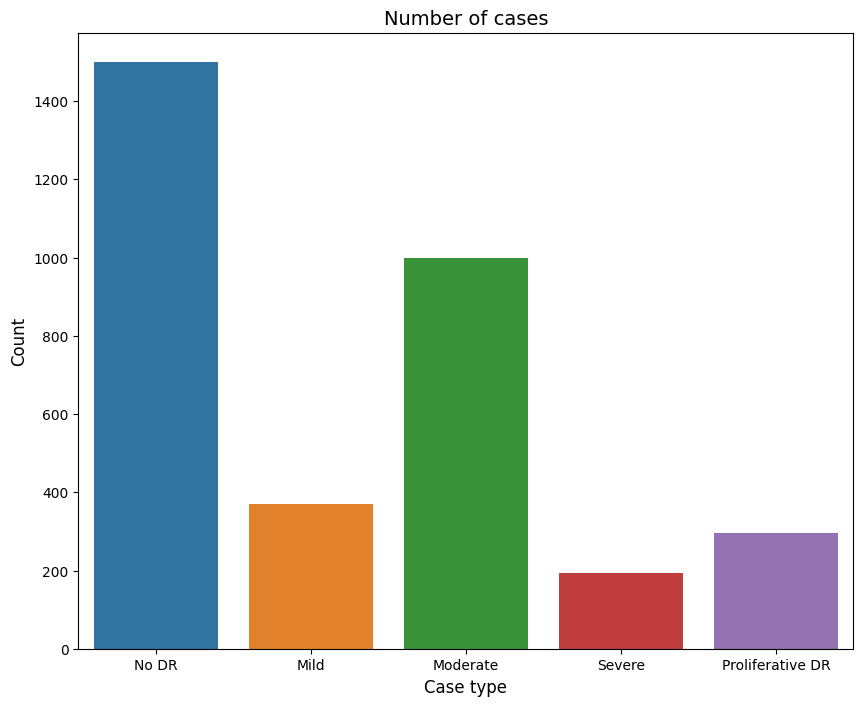

In [6]:
plt.figure(figsize=(10,8))
sns.barplot(x=unique, y= counts)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(unique)), ['No DR', 'Mild','Moderate','Severe', 'Proliferative DR' ])
plt.show()

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y), y = Y)
class_weights = dict(zip(np.unique(Y), class_weights))
class_weights

{0: 0.4476,
 1: 1.8145945945945945,
 2: 0.6720720720720721,
 3: 3.478756476683938,
 4: 2.2759322033898304}

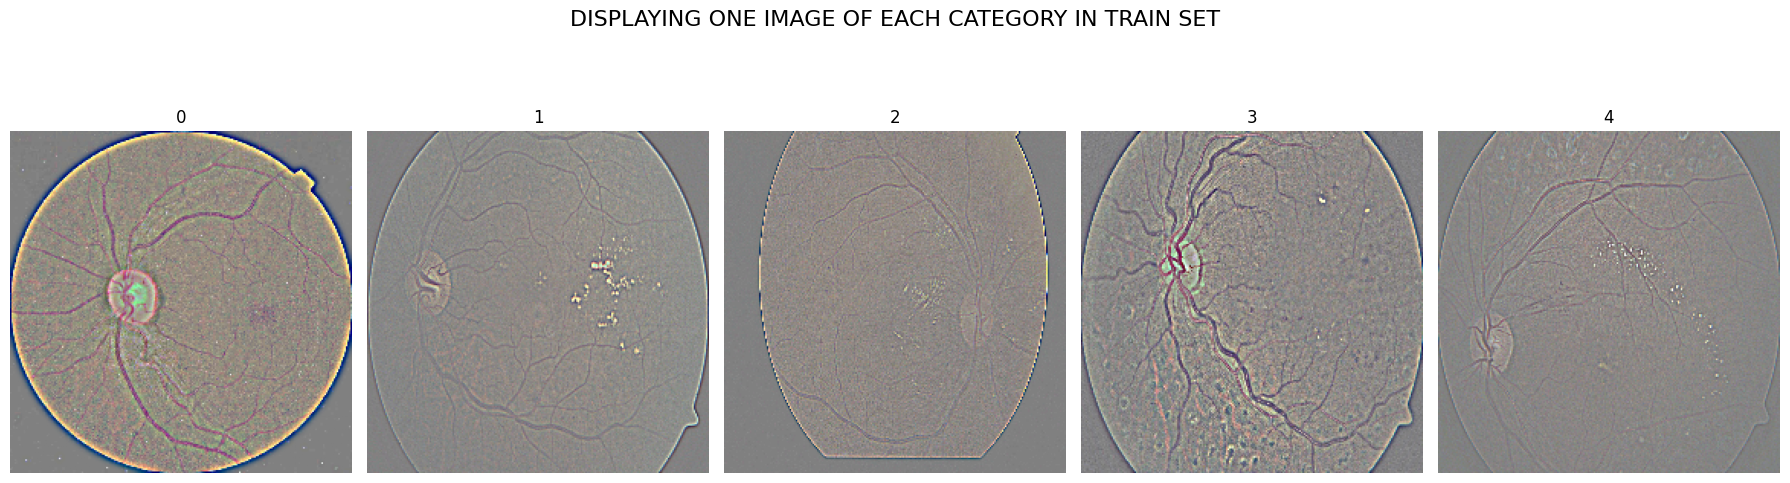

In [8]:
fig, ax= plt.subplots(nrows= 1, ncols= 5, figsize= (18,5))
plt.suptitle('displaying one image of each category in train set'.upper(), 
             y= 1.05, fontsize= 16)

for i in sorted(np.unique(Y)):
    X_image = X[list(Y).index(i)]
    
    ax[i].imshow(X_image)
    ax[i].axis('off')
    ax[i].set_title(i)

plt.tight_layout()
plt.show()

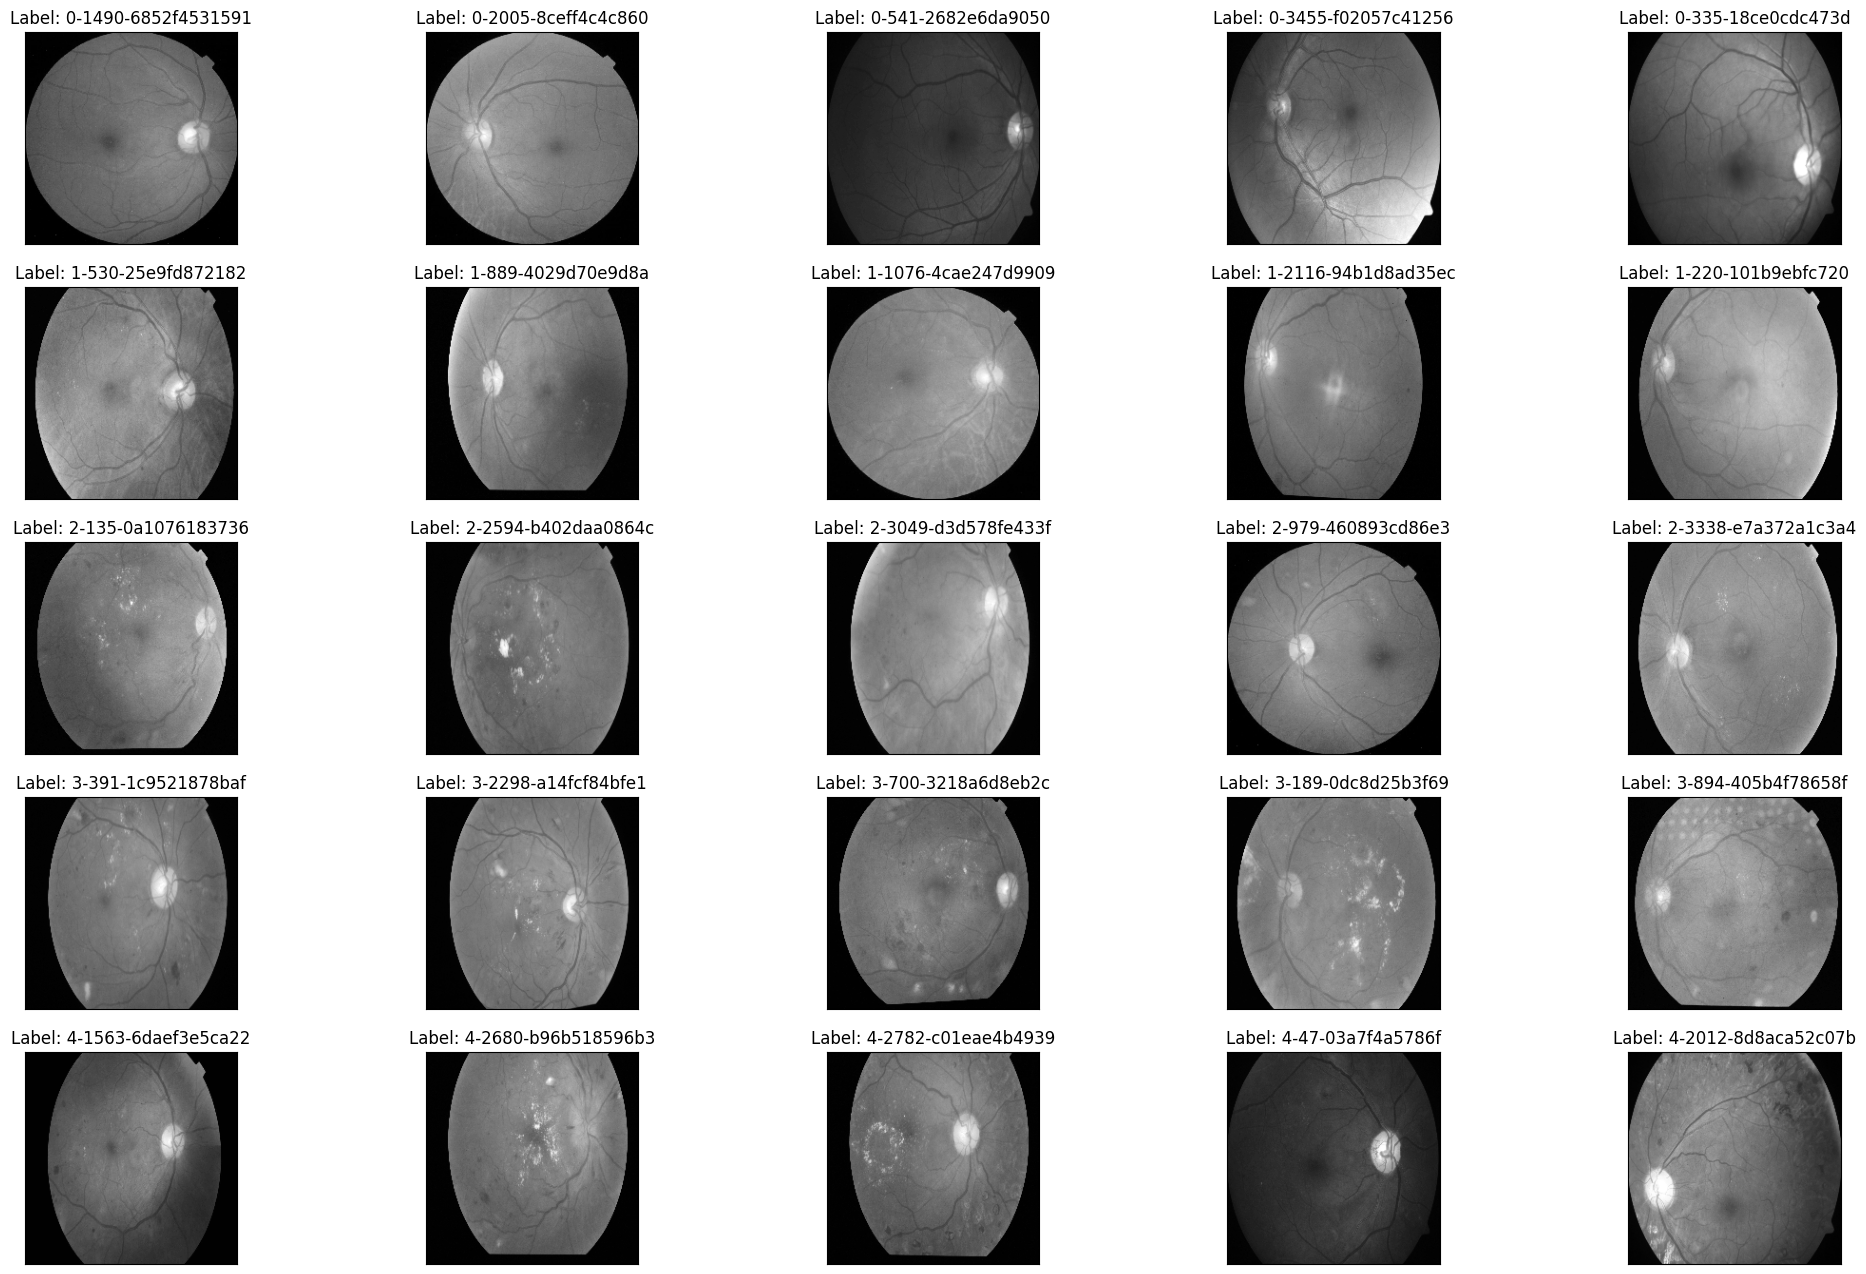

In [9]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(np.unique(Y)):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=2).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"{train_dir}{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (img_size, img_size))

        plt.imshow(image, cmap="gray")
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
auggen = ImageDataGenerator(
        rotation_range=20,       # Rotate by up to 20 degrees
        #width_shift_range=0.1,  # Shift width by 10%
        #height_shift_range=0.1, # Shift height by 10%
        #shear_range=0.2,        # Shear transformation
        zoom_range=0.2,         # Zoom in or out by 20%
        horizontal_flip=True,   # Flip horizontally
        #vertical_flip=True,     # Flip vertically
        #brightness_range=(0.8, 1.2), # Random brightness adjustments
        #fill_mode='nearest'     # Filling mode for pixel values
        )  

## Over-sampling Technique

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
sm = SMOTE(random_state = 2)

In [14]:
X, Y = sm.fit_resample(X.reshape(X.shape[0], -1), Y.ravel())

In [15]:
pd.Series(Y).value_counts()

2    1500
1    1500
4    1500
0    1500
3    1500
Name: count, dtype: int64

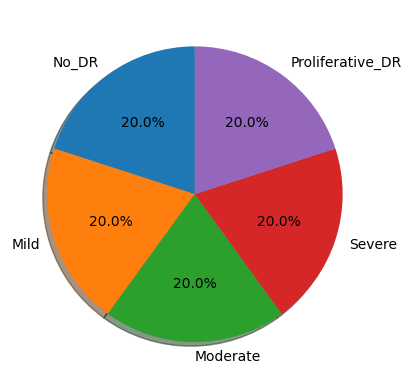

In [16]:
Class_series=pd.Series(Y)
label=["No_DR","Mild","Moderate","Severe","Proliferative_DR"]
DR_stages = Class_series.value_counts().tolist()
values = [DR_stages[0], DR_stages[1], DR_stages[2], DR_stages[3], DR_stages[4]]
fig = plt.pie(Class_series.value_counts(), labels=label, startangle = 90, shadow = True, autopct = "%0.1f%%")

plt.show(fig)

In [17]:
X = X.reshape(X.shape[0], 224, 224, 3)

### Split the data into train, test and validation sets

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True)

In [19]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4800, 224, 224, 3)
(1200, 224, 224, 3)
(1500, 224, 224, 3)


In [49]:
del X,Y

# Model Creation


In [20]:
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten , Dropout , BatchNormalization , MaxPool2D, MaxPooling2D

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size, img_size, 3)))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())

model.add(Conv2D(512 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(256 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(5 , activation = 'softmax'))

In [22]:
#Model Compiling
#opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                        

Decrease learning rate when model converges 

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1, factor=0.1)

In [25]:
callback = [EarlyStopping(monitor = 'val_loss' , patience=10, restore_best_weights=True)
          , ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8 , verbose=1)]

# Model Training 

In [26]:
EPOCHS = 15
BS = 16

In [27]:
datagen = ImageDataGenerator()

In [28]:
H = model.fit(datagen.flow(X_train,Y_train, batch_size= BS), epochs = EPOCHS , 
                   validation_data = datagen.flow(X_val, Y_val),
                    callbacks = [learning_rate_reduction])#, class_weight=class_weights)

Epoch 1/15
300/300 [==============================] - 14s 35ms/step - loss: 1.2998 - accuracy: 0.4815 - val_loss: 2.1065 - val_accuracy: 0.2008 - lr: 1.0000e-04
Epoch 2/15
300/300 [==============================] - 10s 33ms/step - loss: 0.9911 - accuracy: 0.5990 - val_loss: 1.2151 - val_accuracy: 0.4708 - lr: 1.0000e-04
Epoch 3/15
300/300 [==============================] - 10s 33ms/step - loss: 0.7607 - accuracy: 0.7017 - val_loss: 0.8529 - val_accuracy: 0.6675 - lr: 1.0000e-04
Epoch 4/15
300/300 [==============================] - 10s 33ms/step - loss: 0.4831 - accuracy: 0.8227 - val_loss: 1.0565 - val_accuracy: 0.6450 - lr: 1.0000e-04
Epoch 5/15
300/300 [==============================] - 10s 34ms/step - loss: 0.2948 - accuracy: 0.8990 - val_loss: 1.0199 - val_accuracy: 0.6900 - lr: 1.0000e-04
Epoch 6/15
300/300 [==============================] - 10s 34ms/step - loss: 0.1798 - accuracy: 0.9400 - val_loss: 0.4778 - val_accuracy: 0.8525 - lr: 1.0000e-04
Epoch 7/15
300/300 [==============

In [29]:
model.evaluate(X_test,Y_test, verbose = 1)

47/47 [==============================] - 1s 24ms/step - loss: 0.2257 - accuracy: 0.9373


[0.22569681704044342, 0.937333345413208]

In [30]:
model.save('Model_1_CNN.h5')

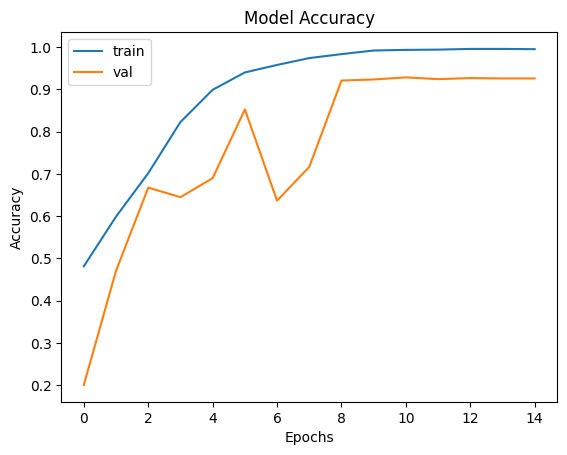

In [31]:
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


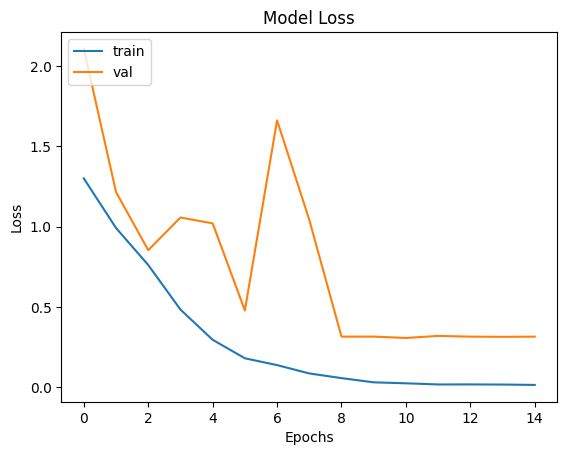

In [32]:
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model Evaluation

In [33]:
from sklearn.metrics import classification_report,confusion_matrix

In [34]:
predictions = model.predict(X_test)
predIdxs = np.argmax(predictions, axis=1)

47/47 [==============================] - 1s 16ms/step


In [35]:
print(classification_report(Y_test, predIdxs))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       286
           1       0.94      0.93      0.93       309
           2       0.92      0.84      0.88       277
           3       0.97      0.97      0.97       319
           4       0.91      0.96      0.94       309

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



Text(95.72222222222221, 0.5, 'Actual')

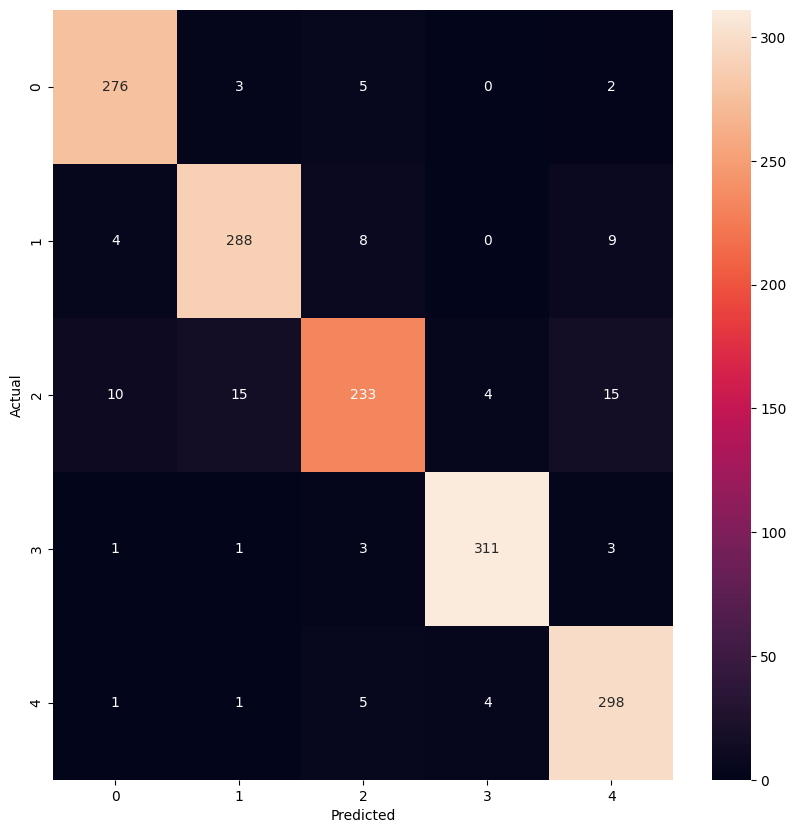

In [36]:
plt.figure(figsize=(10,10))
sns.heatmap(tf.math.confusion_matrix(Y_test, predIdxs), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Extracting features only


In [37]:
from tensorflow.keras.models import Model

In [38]:
extractCNN = Model(model.inputs, model.layers[-8].output)

In [39]:
features_train  = extractCNN.predict(X_train)  
features_test = extractCNN.predict(X_test) 

47/47 [==============================] - 1s 12ms/step


In [40]:
print(features_train.shape)
print(features_test.shape)

(4800, 8192)
(1500, 8192)


## SVM classifier

In [41]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf',decision_function_shape="ovo")

In [42]:
svm.fit(features_train, Y_train)

SVC(decision_function_shape='ovo')

In [43]:
TrainSVMScore=svm.score(features_train, Y_train)*100
TestSVMScore=svm.score(features_test, Y_test)*100

print("SVM Training Accuracy:-",TrainSVMScore)
print("SVM Testing Accuracy:-",TestSVMScore)

SVM Training Accuracy:- 99.52083333333334
SVM Testing Accuracy:- 94.6


In [48]:
import joblib
joblib.dump(svm, "SVM_Classifier.h5")

['SVM_Classifier.h5']

In [45]:
spredictions = svm.predict(features_test)

In [46]:
print(classification_report(Y_test, spredictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       286
           1       0.92      0.95      0.94       309
           2       0.92      0.86      0.89       277
           3       0.97      0.97      0.97       319
           4       0.95      0.97      0.96       309

    accuracy                           0.95      1500
   macro avg       0.95      0.94      0.94      1500
weighted avg       0.95      0.95      0.95      1500



Text(95.72222222222221, 0.5, 'Actual')

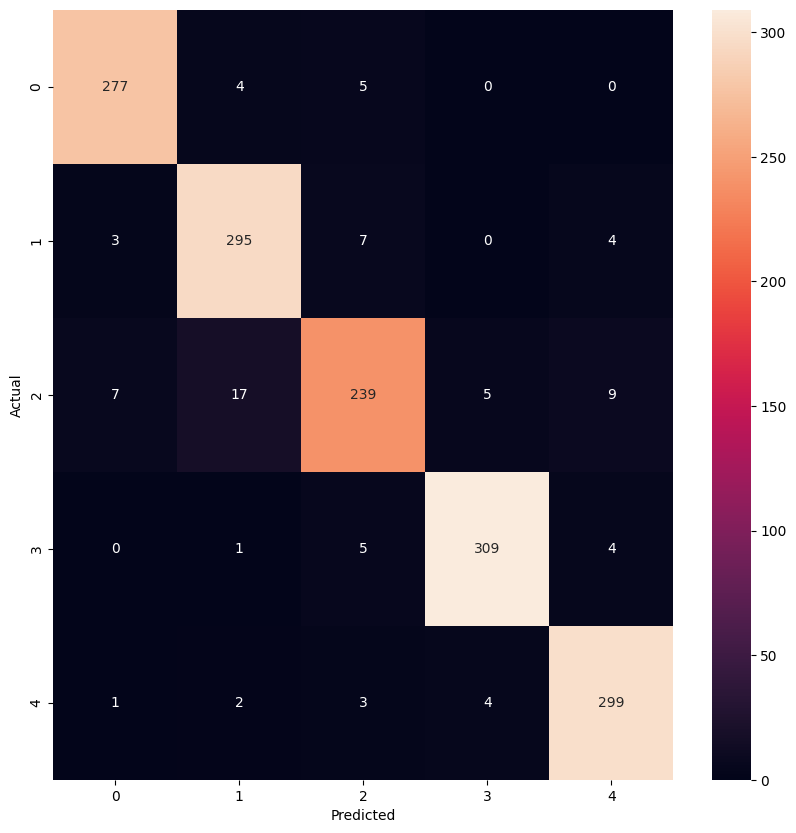

In [47]:
plt.figure(figsize=(10,10))
sns.heatmap(tf.math.confusion_matrix(Y_test, spredictions), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## Random Forest Classifier

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, max_depth=12, random_state=42)

In [51]:
rf.fit(features_train, Y_train)

RandomForestClassifier(max_depth=12, n_estimators=250, random_state=42)

In [52]:
TrainRFScore=rf.score(features_train, Y_train)*100
TestRFScore=rf.score(features_test, Y_test)*100

print("RF Training Accuracy:-",TrainRFScore)
print("RF Testing Accuracy:-",TestRFScore)

RF Training Accuracy:- 99.72916666666667
RF Testing Accuracy:- 84.39999999999999


In [53]:
#import joblib
#joblib.dump(rf, "RF_Classifier.h5")

In [54]:
rfpredictions = rf.predict(features_test)

In [55]:
print(classification_report(Y_test, rfpredictions))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       286
           1       0.80      0.83      0.82       309
           2       0.73      0.71      0.72       277
           3       0.90      0.88      0.89       319
           4       0.88      0.84      0.86       309

    accuracy                           0.84      1500
   macro avg       0.84      0.84      0.84      1500
weighted avg       0.84      0.84      0.84      1500



Text(95.72222222222221, 0.5, 'Actual')

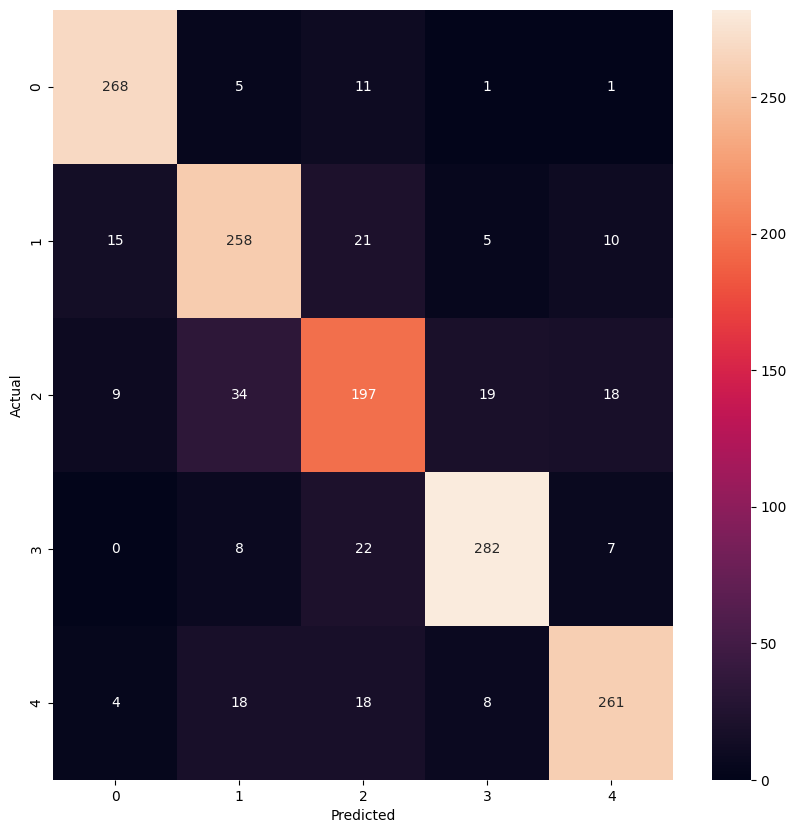

In [56]:
plt.figure(figsize=(10,10))
sns.heatmap(tf.math.confusion_matrix(Y_test, rfpredictions), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## XG Boost Classifier

In [61]:
from xgboost import XGBClassifier

xgb = XGBClassifier() 

In [62]:
xgb.fit(features_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [64]:
TrainXGBScore=xgb.score(features_train, Y_train)*100
TestXGBScore=xgb.score(features_test, Y_test)*100

print("XGB Training Accuracy:-",TrainXGBScore)
print("XGB Testing Accuracy:-",TestXGBScore)

XGB Training Accuracy:- 99.72916666666667
XGB Testing Accuracy:- 89.93333333333334


In [65]:
#import joblib
#joblib.dump(xgb, "XGB_Classifier.h5")

In [66]:
xgbpredictions = xgb.predict(features_test)

In [67]:
print(classification_report(Y_test, xgbpredictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       286
           1       0.88      0.91      0.89       309
           2       0.83      0.79      0.81       277
           3       0.94      0.93      0.94       319
           4       0.90      0.90      0.90       309

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



Text(95.72222222222221, 0.5, 'Actual')

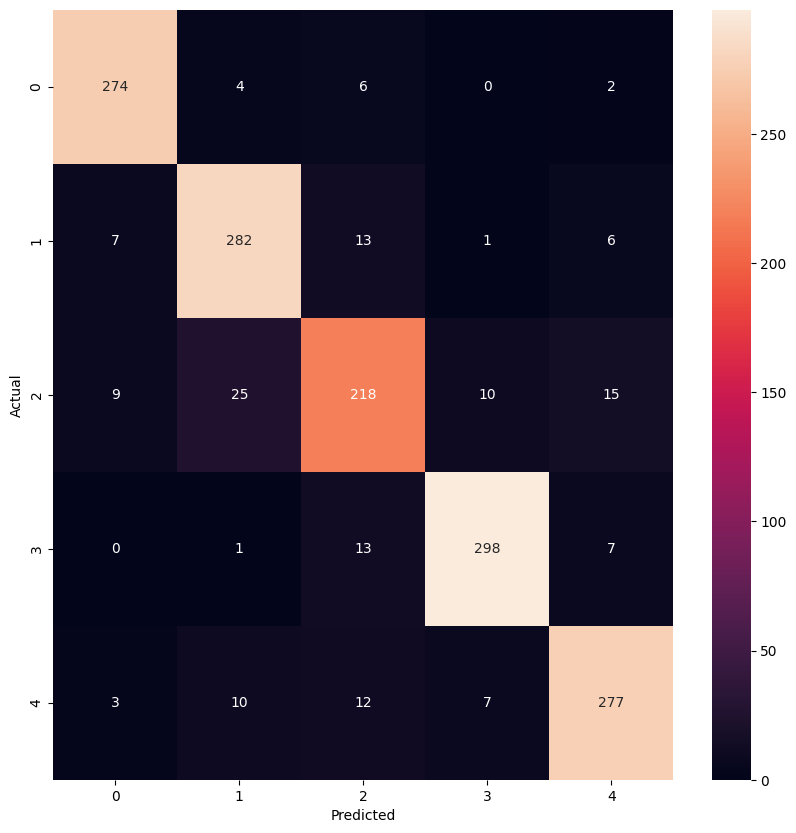

In [68]:
plt.figure(figsize=(10,10))
sns.heatmap(tf.math.confusion_matrix(Y_test, xgbpredictions), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')